# Install detectron2

In [ ]:
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

import torch
assert torch.__version__.startswith("1.7")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html

     |████████████████████████████████| 276kB 17.3MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44076 sha256=76c67c20bc768d849aad3e5bd7d13ba3f254a5214226e8188faccd2893417481
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
1.7.0+cu101 True
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
     |████████████████████████████████| 6.8MB 610kB/s 
     |████████████████████████████████| 2.2MB 11.2MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.2.post20201213-cp36-none-any.whl size=40711 sha256=0ef21a204a632d95ff7d3533e28258bd17b3ed3b6c8b01dcd0d56804ece41c56
  Stored in directory: /root/.cache/pip/wheels/20/eb/f9/b537cf42e3b4c57fe2a49aecad264c775df2d89e0ffbf5b17d
  Created wheel for iopath: filename=iopath-

In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import pandas as pd
import cv2
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



## Data Pre-processing

You can download the data from: https://drive.google.com/drive/folders/147DjN6o9ZpYpQJ_L-9829jHWJxIh9pKg?usp=sharing


1.   You will need to change the PATH_TO_IMAGES variable to the folder containing ALL dataset images (we split into train/test later)
2.   You will need to change the PATH_TO_LABELS variable to the .txt file containing the data labels from Labelme


In [ ]:
'''
Read data with base size and labels

'''

PATH_TO_IMAGES = '/content/drive/MyDrive/Data/CVPartner/Data/Source_Images/Training_Images/vott-csv-export'
PATH_TO_LABELS = '/content/drive/MyDrive/Data/CVPartner/Data/data_train.txt'

f1 = open(PATH_TO_LABELS)
lines = f1.read().split('\n')

lines = [x.split(' ') for x in lines]

for idx in range(len(lines)):
  line = lines[idx]
  im_name = line[0][1 + line[0].rfind('/'):]

  im_path = f'{PATH_TO_IMAGES}/{im_name}'
  line[0] = im_path

lines[:5] # print first 5 examples

[['/content/drive/MyDrive/Data/CVPartner/Data/Source_Images/Training_Images/vott-csv-export/PXL_20201105_160557204.jpg',
  '751,171,1423,790,0'],
 ['/content/drive/MyDrive/Data/CVPartner/Data/Source_Images/Training_Images/vott-csv-export/PXL_20201105_160754098.jpg',
  '2219,1321,2905,2003,0',
  '1794,140,2889,667,0'],
 ['/content/drive/MyDrive/Data/CVPartner/Data/Source_Images/Training_Images/vott-csv-export/PXL_20201105_160818876.jpg',
  '1746,57,2724,413,0',
  '2038,1057,2708,1572,0'],
 ['/content/drive/MyDrive/Data/CVPartner/Data/Source_Images/Training_Images/vott-csv-export/PXL_20201105_160645730.jpg',
  '2059,1300,2392,1831,0'],
 ['/content/drive/MyDrive/Data/CVPartner/Data/Source_Images/Training_Images/vott-csv-export/PXL_20201105_161000362.jpg',
  '537,1162,1245,1660,0',
  '349,343,1267,654,0',
  '1899,270,2794,676,0']]

In [ ]:
'''
Working with 4000x3000 images is slow and unnecessary. I resize the images and 
the bounding box labels to a smaller size. The resized images are saved to a 
folder on Colab and used for training/testing


data is of type list[list]
- Each element corresponds to an image
-- First element is path to the image, second element is the size (h, w) of the image, 
-- third element is a list of bounding boxes (in XYXY format)

'''

def convert_from_yolo(box_list):
  boxes = []

  for box in box_list:
    new_box = tuple(map(int, box[:-2].split(',')))
    boxes.append(new_box)

  return boxes


def convert_bbox(bbox, initial_shape, new_shape):
  ini_x = initial_shape[1]
  ini_y = initial_shape[0]

  new_x = new_shape[1]
  new_y = new_shape[0]

  nx1 = bbox[0]/(ini_x/new_x)
  ny1 = bbox[1]/(ini_y/new_y)

  nx2 = bbox[2]/(ini_x/new_x)
  ny2 = bbox[3]/(ini_y/new_y)

  pt1 = (int(nx1), int(ny1))
  pt2 = (int(nx2), int(ny2))

  return (pt1, pt2)


# Resizing & saving
data = []
os.makedirs('/content/resized', exist_ok=True)

for line in lines:
  im_name = line[0][1 + line[0].rfind('/'):]
  im = cv2.imread(line[0])

  raw_boxes = line[1:]
  ini_shape = (im.shape[1], im.shape[0])
  new_shape = (683, 512)

  boxes = convert_from_yolo(raw_boxes)
  resized_boxes = []

  for box in boxes:
    resized_boxes.append(convert_bbox(box, ini_shape, new_shape))

  new_path = f'/content/resized/{im_name}'

  if not im_name in os.listdir('/content/resized/'):
    im = cv2.resize(im, new_shape)
    cv2.imwrite(new_path, im)

  to_write = [new_path, new_shape, resized_boxes] 
  data.append(to_write)


data[:5]

[['/content/resized/PXL_20201105_160557204.jpg',
  (683, 512),
  [((197, 45), (374, 208))]],
 ['/content/resized/PXL_20201105_160754098.jpg',
  (683, 512),
  [((375, 223), (491, 339)), ((303, 23), (489, 112))]],
 ['/content/resized/PXL_20201105_160818876.jpg',
  (683, 512),
  [((295, 9), (461, 69)), ((345, 179), (458, 266))]],
 ['/content/resized/PXL_20201105_160645730.jpg',
  (683, 512),
  [((542, 342), (629, 482))]],
 ['/content/resized/PXL_20201105_161000362.jpg',
  (683, 512),
  [((90, 196), (210, 281)), ((59, 58), (214, 110)), ((321, 45), (473, 114))]]]

### Dataset Generation

In [ ]:
from detectron2.structures import BoxMode

'''
Converting our dataset into Detectron2's expected dataset format

'''
def get_dataset(data_list, train_or_test='train', test_split=0.8):
  split_idx = int(len(data_list) * test_split)

  train_list = data_list[:split_idx]
  test_list = data_list[split_idx:]

  # determine whether to return the training or testing set
  data_to_return = train_list if train_or_test == 'train' else test_list

  dataset_dicts = []

  for im_list in data_to_return:
    im_dict = {}

    im_name = im_list[0][1 + im_list[0].rfind('/'):]

    im_dict['file_name'] = im_list[0]
    im_dict['height'] = im_list[1][1]
    im_dict['width'] = im_list[1][0]
    im_dict['image_id'] = im_name

    annotations = []

    for box in im_list[2]:
      anno_dict = {}

      anno_dict['bbox'] = box[0] + box[1]
      anno_dict['bbox_mode'] = BoxMode.XYXY_ABS
      anno_dict['category_id'] = 0 # indicates what the marked object is. every labeled object in our dataset is a hole, so only one category id (0)

      annotations.append(anno_dict)

    im_dict['annotations'] = annotations

    dataset_dicts.append(im_dict)

  return dataset_dicts

# registering our dataset and its metadata
for d in ["train", "test"]:
    DatasetCatalog.register("lowes_" + d, lambda d=d: get_dataset(data, d))
    MetadataCatalog.get("lowes_" + d).set(thing_classes=["hole"])

dataset_metadata = MetadataCatalog.get("lowes_train")

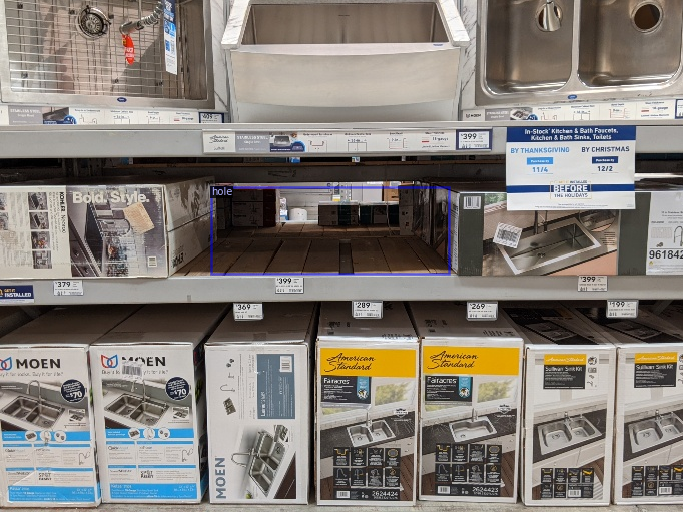

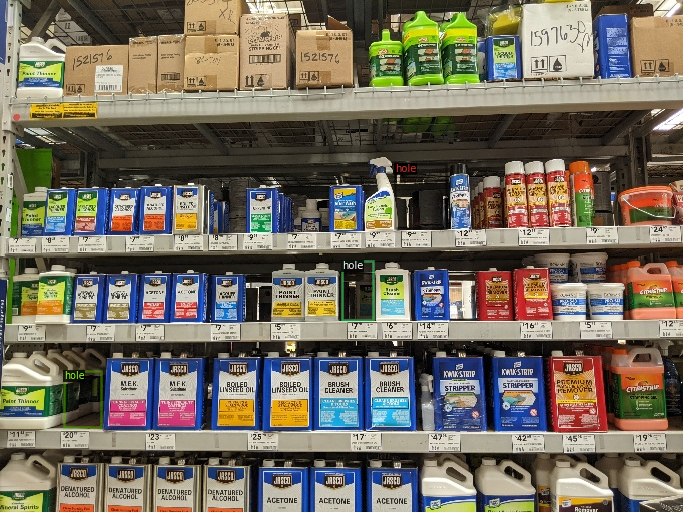

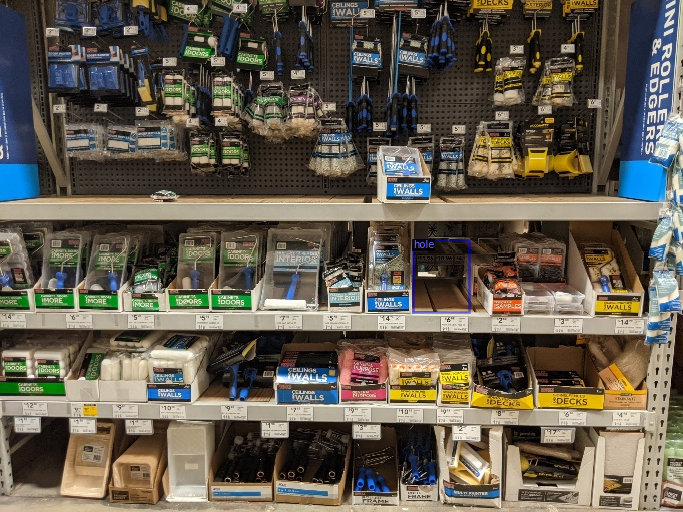

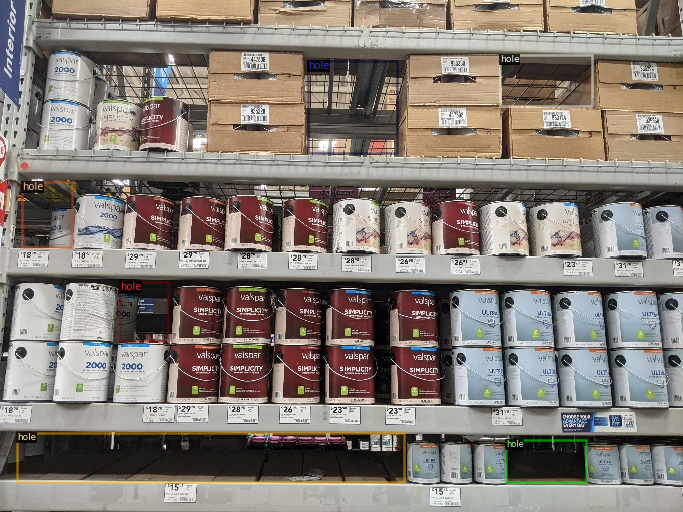

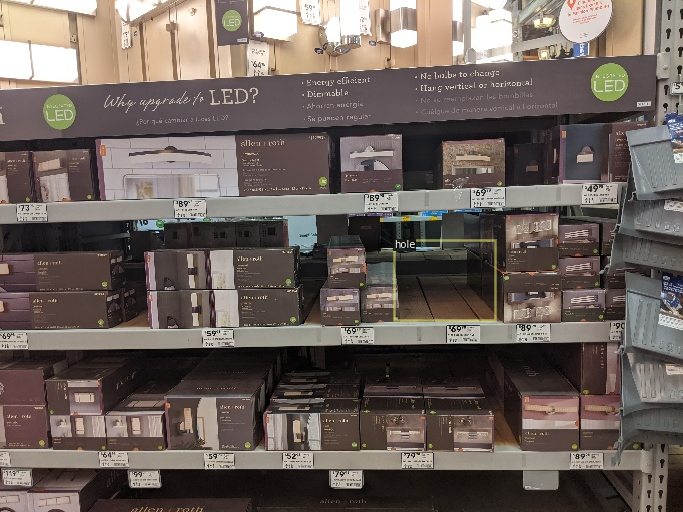

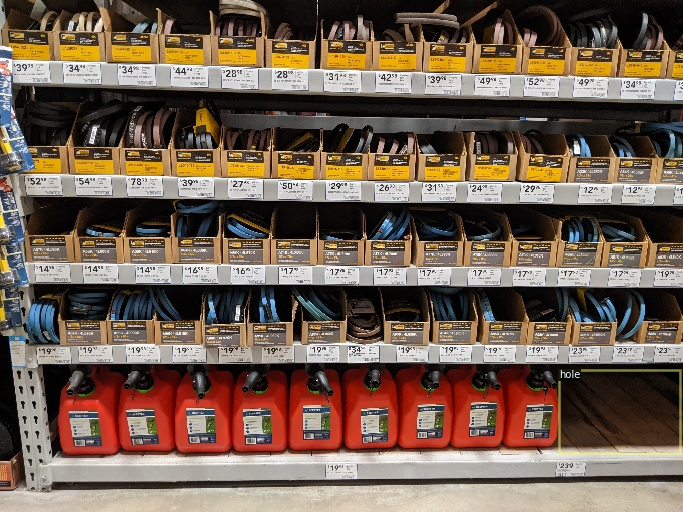

In [ ]:
# Visualizing the dataset (making sure the bounding boxes were correctly resized and the dataset format is correct)
dataset_dicts = get_dataset(data)

for d in random.sample(dataset_dicts, 6):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=dataset_metadata, scale=1)
    out = visualizer.draw_dataset_dict(d)

    vis_im = out.get_image()[:, :, ::-1]
    cv2_imshow(vis_im)

## Training

### Skip this step and go to "Inference" if you downloaded the model in https://drive.google.com/drive/u/2/folders/147DjN6o9ZpYpQJ_L-9829jHWJxIh9pKg

In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file('COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml'))
cfg.DATASETS.TRAIN = ('lowes_train',)
cfg.DATASETS.TEST = ()

cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url('COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml') # use transfer learning
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000
# cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
# cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1 

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

In [ ]:
%load_ext tensorboard
%tensorboard --logdir output

## Inference

Visualizing the results of the model on our testing set




In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file('COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml'))
cfg.DATASETS.TRAIN = ('lowes_train',)
cfg.DATASETS.TEST = ()

cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url('COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml') # use transfer learning
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.WEIGHTS = '/content/drive/MyDrive/Data/CVPartner/Data/model_final.pth'
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.64
predictor = DefaultPredictor(cfg)

In [ ]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_dataset(data, 'test')

for d in random.sample(dataset_dicts, 12):
    im = cv2.imread(d["file_name"])
    im_name = d['image_id']

    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=dataset_metadata, 
                   scale=1
    )

    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    vis_im = out.get_image()[:, :, ::-1]
    
    cv2_imshow(vis_im)
    print('-')

## Evaluations

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("lowes_test", cfg, False, output_dir='/inference')
val_loader = build_detection_test_loader(cfg, "lowes_test")
e_res = inference_on_dataset(predictor.model, val_loader, evaluator)

WARNING [11/27 01:21:34 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass tasks in directly
[11/27 01:21:34 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[11/27 01:21:34 d2.data.common]: Serializing 26 elements to byte tensors and concatenating them all ...
[11/27 01:21:34 d2.data.common]: Serialized dataset takes 0.01 MiB
[11/27 01:21:34 d2.evaluation.evaluator]: Start inference on 26 images
[11/27 01:21:36 d2.evaluation.evaluator]: Inference done 11/26. 0.1006 s / img. ETA=0:00:01
[11/27 01:21:37 d2.evaluation.evaluator]: Total inference time: 0:00:02.219058 (0.105669 s / img per device, on 1 devices)
[11/27 01:21:37 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:02 (0.102072 s / img per device, on 1 devices)
[11/27 01:21:37 d2.evaluation.coco_evaluation]: Preparing results for COCO for